In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, Flatten, Input, Reshape
from keras.callbacks import EarlyStopping
from scipy.integrate import odeint 
import time
import random

2024-10-30 00:10:16.896327: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 00:10:16.905492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 00:10:16.916159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 00:10:16.919436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 00:10:16.928136: I tensorflow/core/platform/cpu_feature_guar

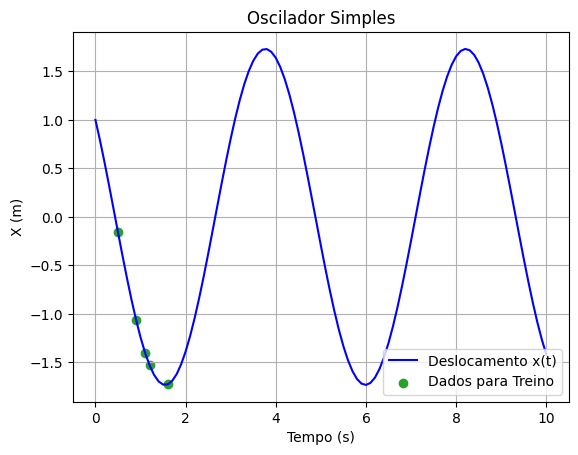

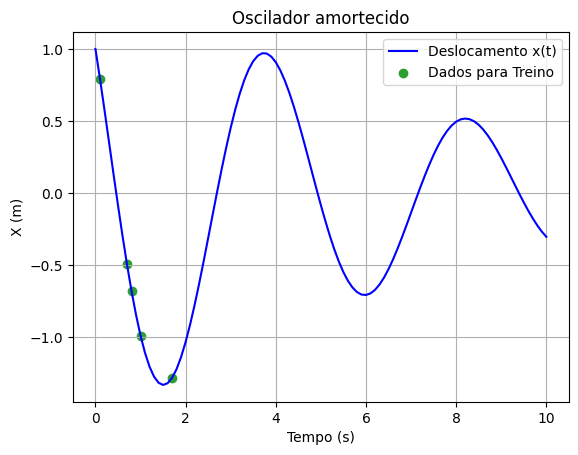

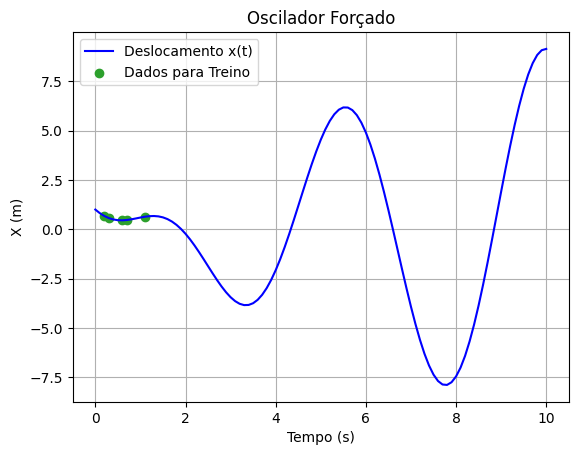

In [46]:
# Parametros
zeta = 0.1                # Fator de amortecimento
k = 2.0                   # Constante da mola
m = 1.0                   # Massa
omega_n = np.sqrt(k*m)    # Frequencia natural
F0 = 5.0                  # Modulo da força
t = np.arange(0, 10.1, 0.1)  # Tempo dt = 0.1

def oscilatorio_simples(y,t):
    u1 = y[1]
    u0 = y[0]
    return [u1, -k/m*u0]

def oscilador_forcado(y, t):
    x1, x2 = y
    dydt = [x2, -2 * zeta * omega_n * x2 - omega_n**2 * x1 + F0*np.cos(omega_n*t)]
    return dydt

def oscilador_amortecido(y, t):
    x1, x2 = y
    dydt = [x2, -2 * zeta * omega_n * x2 - omega_n**2 * x1]
    return dydt

y0 = [1.,-2.]

solucao_simples = odeint(oscilatorio_simples, y0, t)
solucao_forcado = odeint(oscilador_forcado, y0, t)
solucao_amortecido = odeint(oscilador_amortecido, y0, t)


x = tf.expand_dims(t, 1)


y_simples = tf.expand_dims(tf.cast(tf.convert_to_tensor(solucao_simples[:,0]),tf.float32),1)
y_amortecido = tf.expand_dims(tf.cast(tf.convert_to_tensor(solucao_amortecido[:,0]),tf.float32),1)
y_forcado = tf.expand_dims(tf.cast(tf.convert_to_tensor(solucao_forcado[:,0]),tf.float32),1)


n_indices = 5

indices = random.sample(range(1,20), n_indices)
# dados para treinar a rede do oscilador simples
x_data_simples = tf.gather(x,indices)
y_data_simples = tf.gather(y_simples,indices)

ruido_y = tf.random.normal(shape=y_data_simples.shape, mean=0.0, stddev=0.005 * tf.abs(y_data_simples))

y_data_ = y_data_simples + ruido_y


# Plot results
plt.figure()
plt.plot(t, solucao_simples[:, 0], 'b-', label='Deslocamento x(t)')
plt.scatter(x_data_simples, y_data_simples, color="tab:green", label="Dados para Treino")
plt.xlabel('Tempo (s)')
plt.ylabel('X (m)')
plt.legend(loc='best')
plt.title('Oscilador Simples')
plt.grid()
plt.show()

n_indices = 5

indices = random.sample(range(1,20), n_indices)
# dados para treinar a rede do oscilador simples
x_data_amortecido = tf.gather(x,indices)
y_data_amortecido = tf.gather(y_amortecido,indices)

# Plot results
plt.figure()
plt.plot(t, solucao_amortecido[:, 0], 'b-', label='Deslocamento x(t)')
plt.scatter(x_data_amortecido, y_data_amortecido, color="tab:green", label="Dados para Treino")
plt.xlabel('Tempo (s)')
plt.ylabel('X (m)')
plt.legend(loc='best')
plt.title('Oscilador amortecido')
plt.grid()
plt.show()

n_indices = 5

indices = random.sample(range(1,20), n_indices)
# dados para treinar a rede do oscilador simples
x_data_forcado = tf.gather(x,indices)
y_data_forcado = tf.gather(y_forcado,indices)

# Plot results
plt.figure()
plt.plot(t, solucao_forcado[:, 0], 'b-', label='Deslocamento x(t)')
plt.scatter(x_data_forcado, y_data_forcado, color="tab:green", label="Dados para Treino")
plt.xlabel('Tempo (s)')
plt.ylabel('X (m)')
plt.legend(loc='best')
plt.title('Oscilador Forçado')
plt.grid()
plt.show()

In [ ]:
# x da EDO, com 50 pontos
x_phys = tf.linspace(0,15,150)
x_phys = tf.cast(x_phys, tf.float32)
x_phys = tf.expand_dims(x_phys, 1)

#hiperparametros
tf.random.set_seed(5) #fixa a semente para cada teste ser igual
learning_rate = 0.00005
epochs = 100000 
k_phy_loss=(1e1) 

# Arquiteruta do modelo neural, usando o keras
input_dim = 1
hidden_dim = 64
hidden_dim2 = 64
output_dim = 1

model_keras=tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_dim, input_dim=input_dim, use_bias=1,activation='tanh'),
    tf.keras.layers.Dense(hidden_dim2, activation='tanh'),
    tf.keras.layers.Dense(output_dim, activation='linear')
],name='rede_para_PINN')
#model_keras.summary()

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)


/home/henrique/codigos/tensorflow/tfgpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
k_phy_loss=(1e1) 
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [49]:
# Simples
@tf.function
def training_step(x_data,y_data):
    batch_X = x_data
    with tf.GradientTape() as tape:
        yh = model_keras(batch_X) 
        data_loss = tf.reduce_mean(tf.square(yh - y_data))
        with tf.GradientTape() as t2:
          t2.watch(x_phys)
          with tf.GradientTape() as t1:
            t1.watch(x_phys)
            yhp = model_keras(x_phys) 
          dx  = t1.gradient(yhp, x_phys)
        dx2 = t2.gradient(dx, x_phys)
        physics = dx2 + k/m*yhp
        Phys_loss=k_phy_loss*tf.reduce_mean(tf.square(physics))
        loss = Phys_loss + data_loss
    gradients = tape.gradient(loss, model_keras.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_keras.trainable_variables))
    return Phys_loss, data_loss, loss


In [58]:
# Amortecido
@tf.function
def training_step(x_data,y_data):
    batch_X = x_data
    with tf.GradientTape() as tape:
        yh = model_keras(batch_X) 
        data_loss = tf.reduce_mean(tf.square(yh - y_data))
        with tf.GradientTape() as t2:
          t2.watch(x_phys)
          with tf.GradientTape() as t1:
            t1.watch(x_phys)
            yhp = model_keras(x_phys) 
          dx  = t1.gradient(yhp, x_phys)
        dx2 = t2.gradient(dx, x_phys)
        physics = dx2 + 2*zeta*omega_n*dx + omega_n**2*yhp
        Phys_loss=k_phy_loss*tf.reduce_mean(tf.square(physics))
        loss = Phys_loss + data_loss
    gradients = tape.gradient(loss, model_keras.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_keras.trainable_variables))
    return Phys_loss, data_loss, loss


In [69]:
# Forçado
@tf.function
def training_step(x_data,y_data):
    batch_X = x_data
    with tf.GradientTape() as tape:
        yh = model_keras(batch_X) 
        data_loss = tf.reduce_mean(tf.square(yh - y_data))
        with tf.GradientTape() as t2:
          t2.watch(x_phys)
          with tf.GradientTape() as t1:
            t1.watch(x_phys)
            yhp = model_keras(x_phys) 
          dx  = t1.gradient(yhp, x_phys)
        dx2 = t2.gradient(dx, x_phys)
        physics = dx2 + 2*zeta*omega_n*dx + omega_n**2*yhp - F0*tf.math.cos(omega_n*x_phys)
        Phys_loss=k_phy_loss*tf.reduce_mean(tf.square(physics))
        loss = Phys_loss + data_loss
    gradients = tape.gradient(loss, model_keras.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_keras.trainable_variables))
    return Phys_loss, data_loss, loss


In [70]:
h_loss=[]
h_data_loss=[]
h_Phys_loss=[]
mus = []
start_time = time.time()
for epoch in range(epochs):
    loss = training_step(x_data_forcado,y_data_forcado)
    l1,l2,l3 = loss
    h_loss.append(l3)
    h_data_loss.append(l2)
    h_Phys_loss.append(l1)
    if ((epoch+1)%500==0):
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {l3}, Data Loss: {l2}, Physics Loss: {l1}")
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 500/100000, Loss: 119.84200286865234, Data Loss: 0.15881690382957458, Physics Loss: 119.68318939208984
Epoch 1000/100000, Loss: 117.68402099609375, Data Loss: 0.09213276207447052, Physics Loss: 117.59188842773438
Epoch 1500/100000, Loss: 114.9140396118164, Data Loss: 0.16173069179058075, Physics Loss: 114.75231170654297
Epoch 2000/100000, Loss: 110.865966796875, Data Loss: 0.3811594843864441, Physics Loss: 110.48480987548828
Epoch 2500/100000, Loss: 107.54317474365234, Data Loss: 0.7983704209327698, Physics Loss: 106.74480438232422
Epoch 3000/100000, Loss: 106.12847900390625, Data Loss: 1.2653661966323853, Physics Loss: 104.86311340332031
Epoch 3500/100000, Loss: 105.15192413330078, Data Loss: 1.5966559648513794, Physics Loss: 103.55526733398438
Epoch 4000/100000, Loss: 103.95925903320312, Data Loss: 1.9105002880096436, Physics Loss: 102.04875946044922
Epoch 4500/100000, Loss: 102.502197265625, Data Loss: 2.3452680110931396, Physics Loss: 100.15692901611328
Epoch 5000/100000, Los

In [71]:
t_2 = np.arange(0,20,0.1)

In [72]:
prev = model_keras(np.reshape(t_2,(-1,1)))

In [76]:
print(prev[0])

tf.Tensor([1.0137392], shape=(1,), dtype=float32)


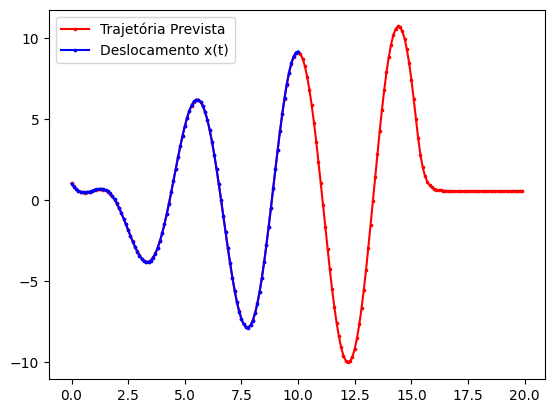

In [73]:
plt.plot(t_2,prev,"ro-",markersize=1.6,label="Trajetória Prevista")
plt.plot(t, solucao_forcado[:, 0], 'bo-', markersize=1.6, label='Deslocamento x(t)')
plt.legend()
plt.show()